In [1]:
import importlib.util

In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import backtrader as bt
from datetime import datetime

In [3]:
spec = importlib.util.spec_from_file_location("PandasRepo", "/Users/dennis/PycharmProjects/IbTrader/PandasRepo.py")
PandasRepoModule = importlib.util.module_from_spec(spec)
spec.loader.exec_module(PandasRepoModule)

In [4]:
class FirstBacktraderStrategy(bt.Strategy):

    def __init__(self):
        self.rsi = dict()
        for symbol in self.getdatanames():
            self.rsi[symbol] = bt.indicators.RSI_SMA(self.getdatabyname(symbol).close, period=21)

    def next(self):
        for symbol in self.getdatanames():
            pos = self.getpositionbyname(symbol).size or 0
            if pos == 0:
                if self.rsi[symbol][0] < 30:
                    self.buy(data=self.getdatabyname(symbol), size=100)
            else:
                if self.rsi[symbol][0] > 70:
                    self.sell(data=self.getdatabyname(symbol), size=100)

In [39]:
class BacktraderWrapper:
    def __init__(self,
                 startCash = 10000,
                 universe = ["IYM", "IYC", "IYK", "IYE", "IYF", "IYH", "IYR", "IYW", "IDU"],
                 startDate = datetime(2016, 1, 1),
                 endDate = datetime(2016, 12, 31)):
        self._startCash = startCash
        self._universe = universe
        self._startDate = startDate
        self._endDate = endDate

    def RunBackTest(self):
        # Create an instance of cerebro
        cerebro = bt.Cerebro()

        # Add our strategy
        cerebro.addstrategy(FirstBacktraderStrategy)

        # Add data feed
        for symbol in self._universe:
            df = PandasRepoModule.PandasRepo().GetData(symbol, self._startDate, self._endDate)
            data = bt.feeds.PandasData(dataname=df)
            cerebro.adddata(data, name=symbol)

        # Set our desired cash start
        cerebro.broker.setcash(self._startCash)

        # Set up pyfolio
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

        # Run over everything
        results = cerebro.run()
        strat = results[0]
        pyfoliozer = strat.analyzers.getbyname('pyfolio')
        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
        
        benchmarkDf = df = PandasRepoModule.PandasRepo().GetData('SPY', self._startDate, self._endDate)
        benchmarkDf = benchmarkDf['Close'].pct_change().fillna(0).tz_localize(tz='UTC')
        benchmarkDf.index.name = 'index'
        
        import matplotlib.pyplot as plt
        plt.plot(returns)
        plt.show()
        
        plt.plot(benchmarkDf)
        plt.show()

        import pyfolio as pf
        #pf.create_round_trip_tear_sheet(returns, positions, transactions, sector_mappings=None)
        pf.create_full_tear_sheet(
            returns,
            positions=positions,
            benchmark_rets = benchmarkDf,
            transactions=transactions,
            gross_lev=gross_lev,
            #live_start_date='2016-01-01',  # This date is sample specific
            round_trips=True)

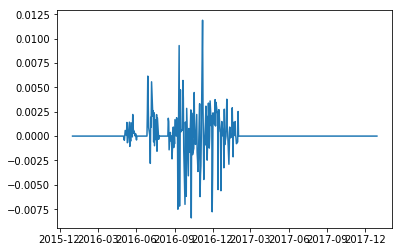

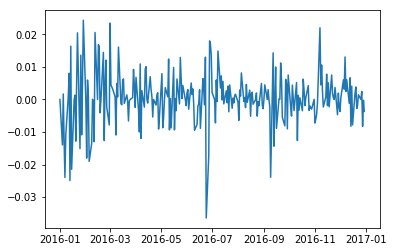

Entire data start date: 2016-01-01
Entire data end date: 2017-12-29


Backtest Months: 24


/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pyfolio/timeseries.py:416: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  beta, alpha = sp.stats.linregress(factor_returns.loc[ret_index].values,


Performance statistics,Backtest
annual_return,0.02
annual_volatility,0.02
sharpe_ratio,0.80
calmar_ratio,0.53
stability_of_timeseries,0.86
max_drawdown,-0.04
omega_ratio,1.30
sortino_ratio,1.16
skew,0.10
kurtosis,15.40


/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pyfolio/plotting.py:688: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  bmark_vol = factor_returns.loc[returns.index].std()


KeyError: "None of [DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',\n               '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11',\n               '2017-01-12', '2017-01-13',\n               ...\n               '2017-06-14', '2017-06-15', '2017-06-16', '2017-06-19',\n               '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23',\n               '2017-06-26', '2017-06-27'],\n              dtype='datetime64[ns, UTC]', name='index', length=127, freq=None)] are in the [index]"

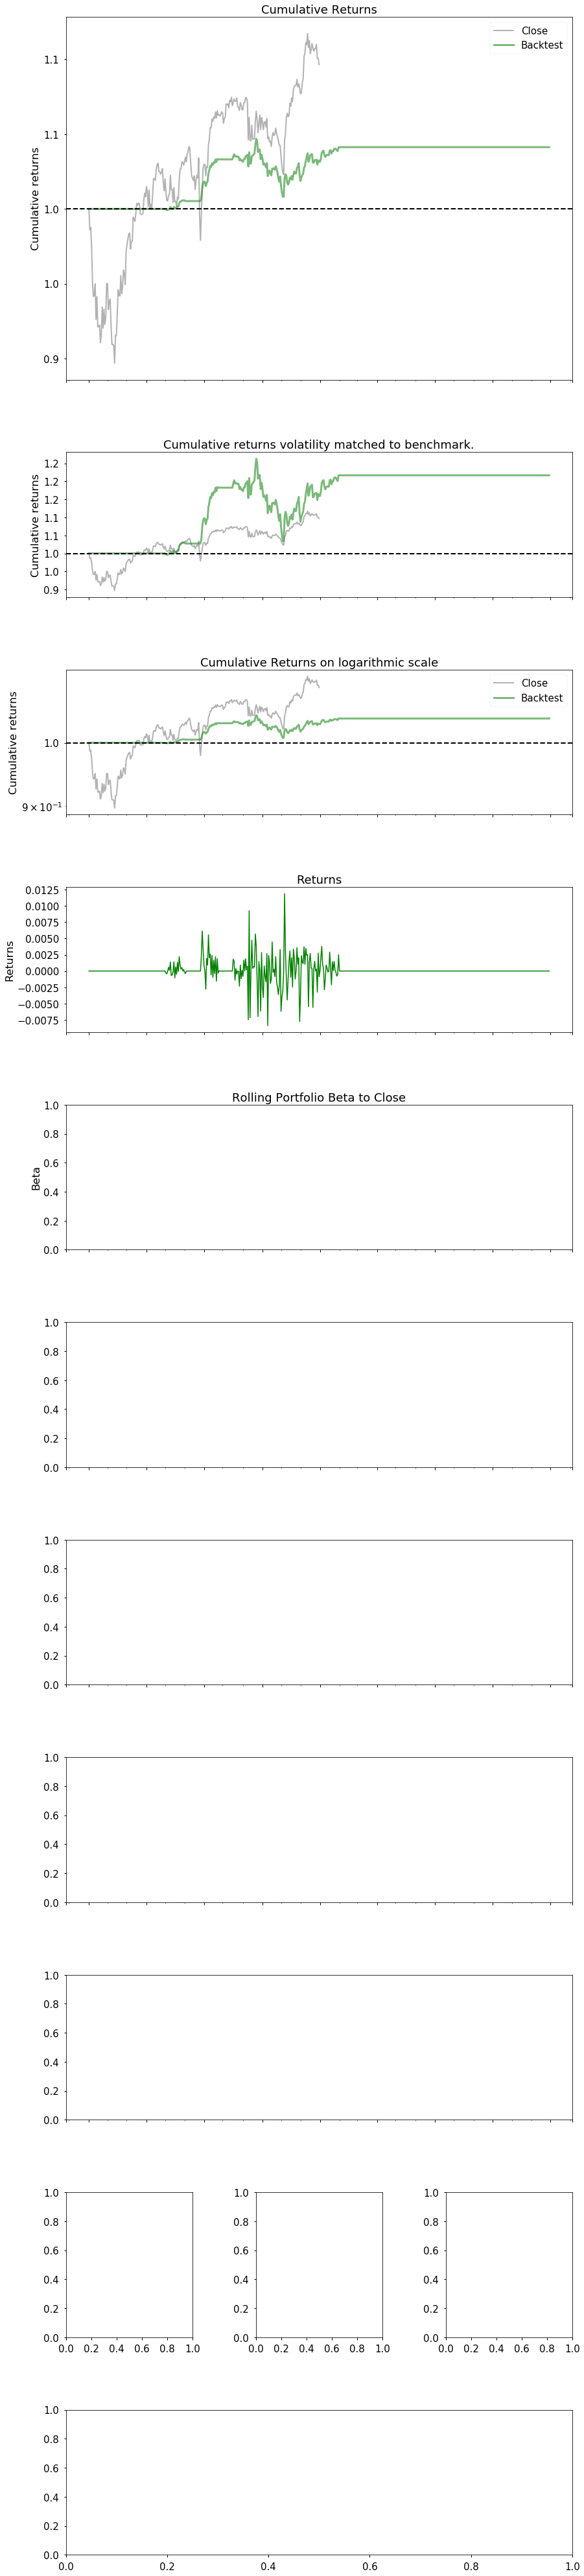

In [40]:
BacktraderWrapper(startCash=100000).RunBackTest()